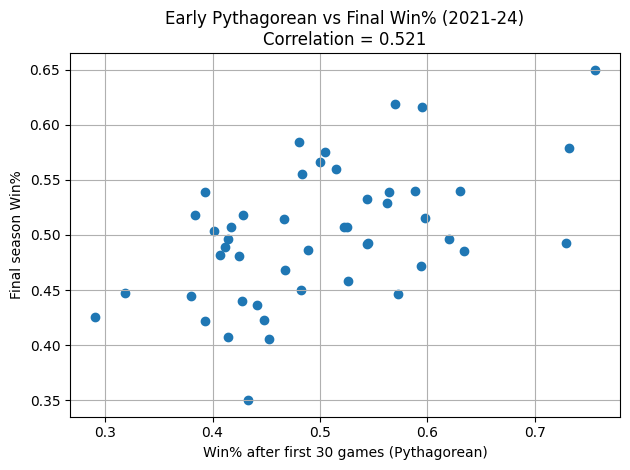

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
# import ace_tools as tools

# ---------- helper functions ----------
def load_season_csv(season):
    """try local and /mnt/data paths"""
    fname = f"games_{season}.csv"
    if os.path.exists(fname):
        return pd.read_csv(fname)
    path2 = f"/mnt/data/{fname}"
    if os.path.exists(path2):
        return pd.read_csv(path2)
    raise FileNotFoundError(fname)

def to_long(df):
    """Convert wide (one row per game) to long (one row per team per game)."""
    rows = []
    for _, r in df.iterrows():
        date = pd.to_datetime(r["date"])
        # home
        rows.append({
            "team": r["team_home"],
            "date": date,
            "RS": r["R_home"],
            "RA": r["R_away"],
            "win": 1 if r["R_home"] > r["R_away"] else 0,
            "loss": 1 if r["R_home"] < r["R_away"] else 0,
            "tie": 1 if r["R_home"] == r["R_away"] else 0
        })
        # away
        rows.append({
            "team": r["team_away"],
            "date": date,
            "RS": r["R_away"],
            "RA": r["R_home"],
            "win": 1 if r["R_away"] > r["R_home"] else 0,
            "loss": 1 if r["R_away"] < r["R_home"] else 0,
            "tie": 1 if r["R_home"] == r["R_away"] else 0
        })
    return pd.DataFrame(rows)

def aggregate_stats(team_games):
    """Return dict of wins, losses, ties, RS, RA."""
    wins = team_games["win"].sum()
    losses = team_games["loss"].sum()
    ties = team_games["tie"].sum()
    RS = team_games["RS"].sum()
    RA = team_games["RA"].sum()
    # avoid division by zero
    wl_games = wins + losses
    win_pct = wins / wl_games if wl_games else np.nan
    pyth = RS**2 / (RS**2 + RA**2) if (RS + RA) else np.nan
    return win_pct, pyth, wins, losses, ties, RS, RA

# ---------- build season-team stats ----------
records = []
seasons = [2021, 2022, 2023, 2024]

for season in seasons:
    df = load_season_csv(season)
    # ensure columns consistent
    rename_map = {}
    for col in df.columns:
        if col.lower() == "r_home" and "R_home" not in df.columns:
            rename_map[col] = "R_home"
        if col.lower() == "r_away" and "R_away" not in df.columns:
            rename_map[col] = "R_away"
    if rename_map:
        df = df.rename(columns=rename_map)
    long_df = to_long(df)
    # sort by date for each team
    long_df = long_df.sort_values("date")
    for team, g in long_df.groupby("team"):
        g = g.sort_values("date")
        early = g.head(30)
        early_win_pct, early_pyth, _, _, _, _, _ = aggregate_stats(early)
        final_win_pct, final_pyth, wins, losses, ties, RS, RA = aggregate_stats(g)
        records.append({
            "season": season,
            "team": team,
            "early_win_pct": early_win_pct,
            "early_pyth_pct": early_pyth,
            "final_win_pct": final_win_pct,
            "final_pyth_pct": final_pyth,
            "win_improve": final_win_pct - early_win_pct
        })

stats_df = pd.DataFrame(records)

# -------- correlation analysis ----------
corr_ep_final = stats_df["early_pyth_pct"].corr(stats_df["final_win_pct"])
corr_early_actual_final = stats_df["early_win_pct"].corr(stats_df["final_win_pct"])

# -------- scatter plot ----------
plt.figure()
plt.scatter(stats_df["early_pyth_pct"], stats_df["final_win_pct"])
plt.title(f"Early Pythagorean vs Final Win% (2021-24)\nCorrelation = {corr_ep_final:.3f}")
plt.xlabel("Win% after first 30 games (Pythagorean)")
plt.ylabel("Final season Win%")
plt.grid(True)
plt.tight_layout()
# display plot
plt.show()

# -------- list top improvements ----------
improve_df = stats_df.sort_values("win_improve", ascending=False)
# show top 10
top10 = improve_df.head(10).reset_index(drop=True)
# tools.display_dataframe_to_user("Top 10 Improvements (Final Win% - Early Win%)", top10)


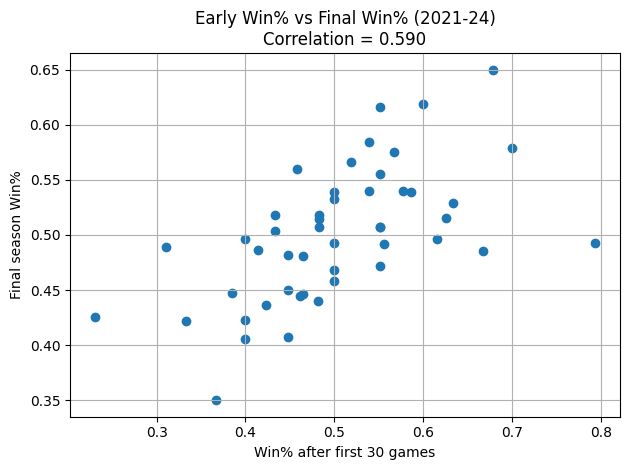

In [5]:
# -------- scatter plot ----------
plt.figure()
plt.scatter(stats_df["early_win_pct"], stats_df["final_win_pct"])
plt.title(f"Early Win% vs Final Win% (2021-24)\nCorrelation = {corr_early_actual_final:.3f}")
plt.xlabel("Win% after first 30 games")
plt.ylabel("Final season Win%")
plt.grid(True)
plt.tight_layout()
# display plot
plt.show()